### Importing libraries


In [425]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Importing the dataset
dataset = pd.read_csv('50_Startups.csv')


### Data Preprocessing

#### After checking data for null values, getting statistical summary and checking data types.

In [376]:
print(dataset.shape)
print(dataset.head(5))

(50, 5)
   R&D Spend  Administration  Marketing Spend       State     Profit
0  165349.20       136897.80        471784.10    New York  192261.83
1  162597.70       151377.59        443898.53  California  191792.06
2  153441.51       101145.55        407934.54     Florida  191050.39
3  144372.41       118671.85        383199.62    New York  182901.99
4  142107.34        91391.77        366168.42     Florida  166187.94


In [15]:
dataset.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [19]:
display(dataset.isnull().sum())

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

In [20]:
dataset. State.nunique()
dataset['State'].value_counts()

New York      17
California    17
Florida       16
Name: State, dtype: int64

### Dummy variable

#### As we want to take State variable in the analysis, I changed it into dummies by pd.get_dummies as below.

In [426]:
df1=pd.get_dummies(dataset, columns=['State'])
df1.head(6)

,R&D Spend,Administration,Marketing Spend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0,0,1
1,162597.70,151377.59,443898.53,191792.06,1,0,0
2,153441.51,101145.55,407934.54,191050.39,0,1,0
3,144372.41,118671.85,383199.62,182901.99,0,0,1
4,142107.34,91391.77,366168.42,166187.94,0,1,0
5,131876.90,99814.71,362861.36,156991.12,0,0,1


### EDA

#### By boxplot, I checked outliers, there is no outlier in the variables. After this I plotted distribution of other numeric variables as below.

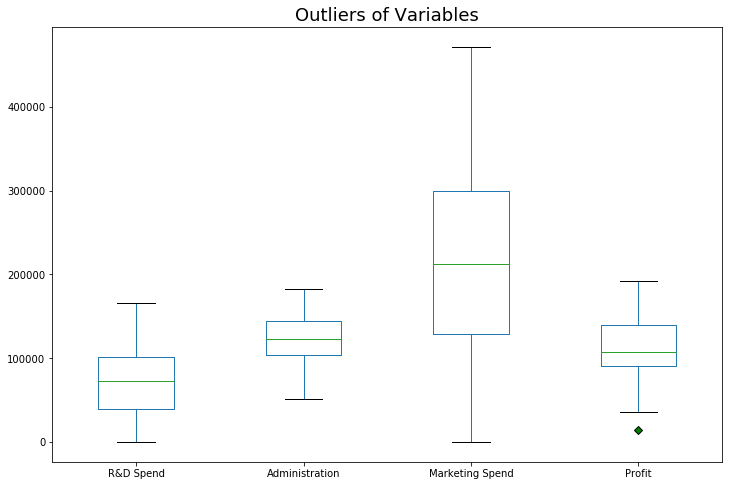

In [337]:
green_diamond = dict(markerfacecolor='g', marker='D')
boxplot2 = dataset.boxplot(figsize=(12,8), grid=False, flierprops=green_diamond)
plt.title('Outliers of Variables', fontsize=18);

Text(0.5, 1.0, 'Histogram Plots for all Numeric Variables')

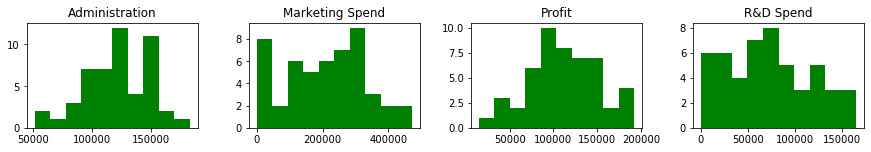

In [24]:
dataset.hist(layout=(5,4),color='green', figsize=(15,12), grid=False)
plt.title("Histogram Plots for all Numeric Variables")

In [75]:
df=dataset.drop(columns='State')
#df.head(3)

#### To check whether variables are normal, I also plotted q-q plot. As qq plots are not very conclusive, I also took shapiro wilk test and according to Shapiro-Wilk test, all variables are normal.

QQ plot of: R&D Spend


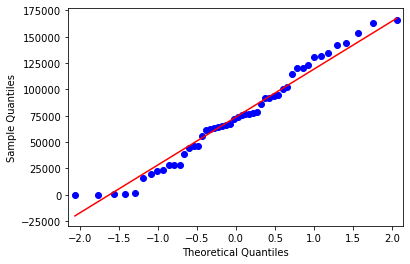

QQ plot of: Administration


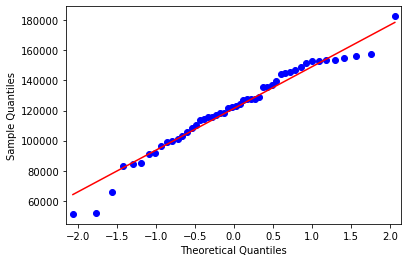

QQ plot of: Marketing Spend


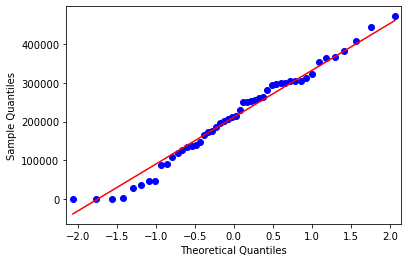

QQ plot of: Profit


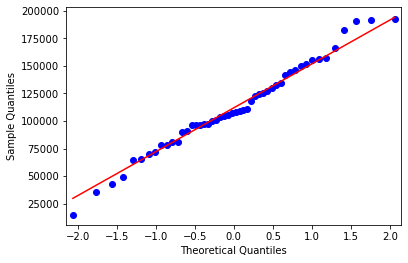

In [27]:
import statsmodels.api as sm
import pylab

for idx, val in enumerate(df):
    print('QQ plot of:', val)
    sm.qqplot(df[val], line='s')
    plt.show()

In [61]:
from scipy import stats
for idx, val in enumerate(df):
    print('Shapiro Wilk test:(test statistics, p-value)', val)
    print(stats.shapiro(df[val]))

Shapiro Wilk test:(test statistics, p-value) R&D Spend
(0.9673413634300232, 0.18005183339118958)
Shapiro Wilk test:(test statistics, p-value) Administration
(0.9702357649803162, 0.23660743236541748)
Shapiro Wilk test:(test statistics, p-value) Marketing Spend
(0.9743662476539612, 0.3450772166252136)
Shapiro Wilk test:(test statistics, p-value) Profit
(0.9848830103874207, 0.766564130783081)


### Multicollinearity

#### Below heat map shows, R&D Spend is highly correlated with Marketing Spend. So, I used VIF all values are below 8.3, therefore didn't remove any variables. Also in the heat map, R&D Spend(independent variable) is highly correlated with Profit(dependent variable). 

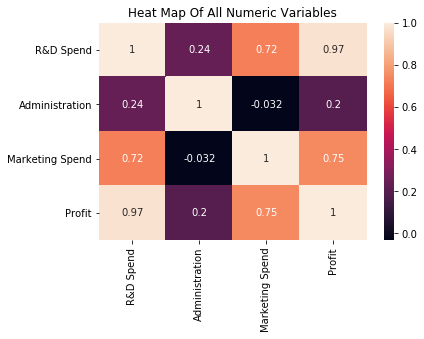

In [28]:
import seaborn as sns
sns.heatmap(dataset.corr(), annot=True).set(title="Heat Map Of All Numeric Variables")

plt.show()

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif["features"] = df.columns
vif

,VIF Factor,features
0,8.384571,R&D Spend
1,4.026406,Administration
2,7.593984,Marketing Spend


In [429]:
X=df1.drop(columns=['Profit']).values
y=df1.iloc[:,3].values


### Multiple linear regression

#### Below I divided the data into two sets: training(2/3) and test(1/3). After this, I applied linear regression and got coefficient of determination for training data set(0.958) and test set(0.875), which is very good fit. Although model is taking all the variables in the model but after looking the statistical summary of the model, I found only R&D Spend is statistically significant and intercept is 0.0163. 

In [430]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=1/3, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [431]:
regressor=LinearRegression()
regressor.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [432]:
y_pred=regressor.predict(X_test)
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))
MSEs=cross_val_score(regressor,X_train, y_train,scoring='neg_mean_squared_error')
mean_MSE=np.mean(MSEs)
print(mean_MSE)

0.9576035764205424
0.8752655285748304
-0.06958481467335136


In [433]:
regressor.coef_


array([ 0.94338246,  0.03503234,  0.06731366, -0.04668547,  0.10184769,
       -0.05516221])

## Residual Plot

### Residual plot suggests that the assumption of homegeneous, independence and normality are met.

Text(0.5, 1.0, 'Residual Plot')

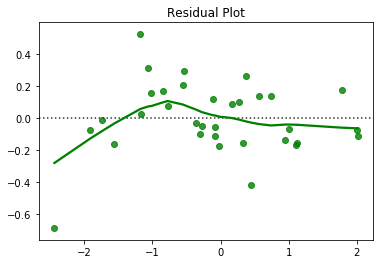

In [437]:
regressor.fit(X_train,y_train)
y_pred=regressor.predict(X_train)
residual=(y_train-y_pred)

sns.residplot( x=y_train,y=residual,lowess=True, color="g")
plt.title('Residual Plot')

In [101]:
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     122.0
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           1.18e-17
Time:                        10:55:23   Log-Likelihood:                 2.5837
No. Observations:                  33   AIC:                             6.833
Df Residuals:                      27   BIC:                             15.81
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0163      0.037      0.441      0.6

## Lasso Regression

#### Lasso is the word used for catching animals but here lasso regression is the way, we can catch our significant variables. In statistics and machine learning, lasso is a penalized regressionanalysis method that performs both variable selection and regularization in order to enhance the prediction accuracy. It is also known as L1 regularization. This is a good method for variable slelection as it makes the coefficient values of insignificant variables to 0. 

#### Below I used sklearn library for lasso regression but for tuning parameter, it is very important to choose right value of λ. As λ increases bias increases. To take care of this, I used gridsearchCV method to get the optimum value of tuning parameter. 

#### Below we got 0.1 as optimum value of tuning parameter. Here best scores are negative MSE scores, i.e. negate them and we get the MSE. GridSearchCV, by convention, always tries to maximize its score so loss functions like MSE have to be negated. I got 0.0674 MSE of training set and 0.04 MSE for test set.

#### 



In [341]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.arange(0.01, 10, 0.1)
tuned_parameters = [{'alpha': alphas}]
n_folds = 5
clf = GridSearchCV(lasso, tuned_parameters,scoring='neg_mean_squared_error',cv=n_folds, refit=True)

m=clf.fit(X_train, y_train)
print(m.best_params_)
print(m.best_score_)

{'alpha': 0.01}
-0.06745304930752874


In [173]:
tuned_parameters

[{'alpha': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,
         1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91, 2.01, 2.11,
         2.21, 2.31, 2.41, 2.51, 2.61, 2.71, 2.81, 2.91, 3.01, 3.11, 3.21,
         3.31, 3.41, 3.51, 3.61, 3.71, 3.81, 3.91, 4.01, 4.11, 4.21, 4.31,
         4.41, 4.51, 4.61, 4.71, 4.81, 4.91, 5.01, 5.11, 5.21, 5.31, 5.41,
         5.51, 5.61, 5.71, 5.81, 5.91, 6.01, 6.11, 6.21, 6.31, 6.41, 6.51,
         6.61, 6.71, 6.81, 6.91, 7.01, 7.11, 7.21, 7.31, 7.41, 7.51, 7.61,
         7.71, 7.81, 7.91, 8.01, 8.11, 8.21, 8.31, 8.41, 8.51, 8.61, 8.71,
         8.81, 8.91, 9.01, 9.11, 9.21, 9.31, 9.41, 9.51, 9.61, 9.71, 9.81,
         9.91])}]

In [342]:
lasso = Lasso(random_state=0, max_iter=10000, alpha=0.1)

In [343]:
lasso = Lasso(random_state=0, max_iter=10000, alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False)

In [346]:
q=lasso.predict(X_test)
mean_squared_error(q,y_test ) ### Test set prediction

0.04027875024087039

In [348]:
lasso_coef = lasso.coef_
print(lasso_coef)

[ 0.87893917  0.          0.03641587 -0.          0.         -0.        ]


In [349]:
df3=df1.drop(columns=['Profit'])
col=df3.columns
col

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'State_California',
       'State_Florida', 'State_New York'],
      dtype='object')

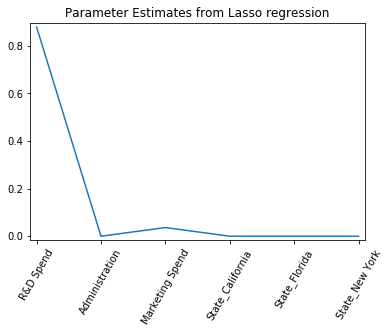

In [351]:
plt.plot(range(len(col)), lasso_coef)
plt.xticks(range(len(col)), col.values, rotation=60) 
plt.margins(0.02)
plt.title("Parameter Estimates from Lasso regression")
plt.show()

### Regularization path of the Lasso 


Text(0.5, 1.0, 'Lasso Coefficient Paths')

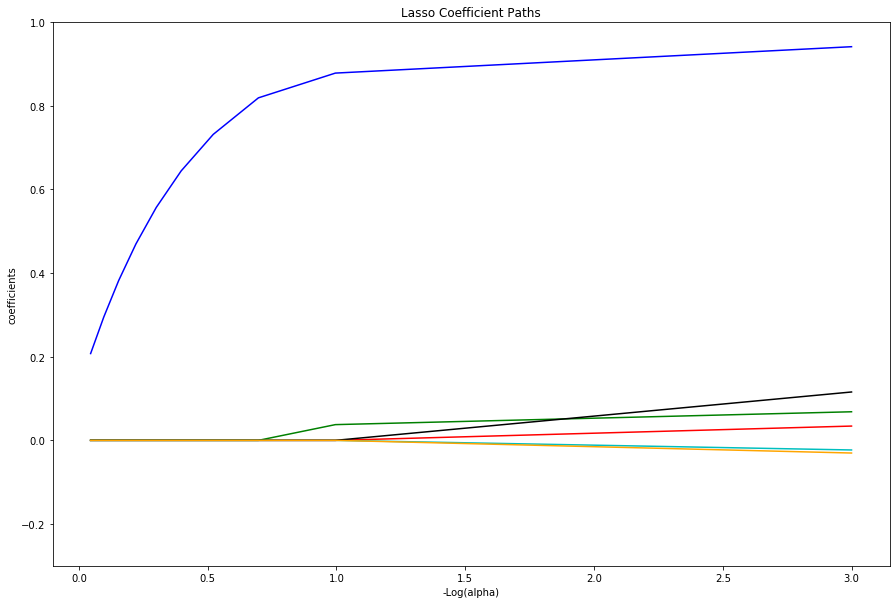

In [237]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import lars_path, lasso_path, ElasticNet
lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.arange(0.001, 1, 0.1)
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, alphas=alphas, copy_X=True, eps=1e-20)
from itertools import cycle
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
colors = cycle(['b', 'r', 'g', 'c', 'k', 'orange'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l,c in zip(coefs_lasso,colors):
    l1 = plt.plot(neg_log_alphas_lasso.T, coef_l, c=c)
plt.ylim([-0.3,1])
plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Coefficient Paths')


In [230]:
len(coef_l)

1

### Ridge Regression

#### I got MSE 0.069 for training set and 0.072 for test set. Coefficients are also given below. I got alpha 0.1 as best parameter.

In [236]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
ridge = Ridge(random_state=0, max_iter=10000)
alphas = np.arange(0.1, 10, 0.01)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5
clf = GridSearchCV(ridge, tuned_parameters,scoring='neg_mean_squared_error',cv=n_folds, refit=False)
km=clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'alpha': 0.1}
-0.06958207127412334


In [238]:
ridge = Ridge(random_state=0, max_iter=10000, alpha=0.1)

In [239]:
ridge.fit(X_train, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=0, solver='auto', tol=0.001)

In [241]:
ridge_coef = ridge.coef_
print(ridge_coef)

[ 0.9359537   0.03692788  0.07246446 -0.04517756  0.09691468 -0.05173713]


In [248]:
q=ridge.predict(X_test)
mean_squared_error(q,y_test )

0.07249013148226024

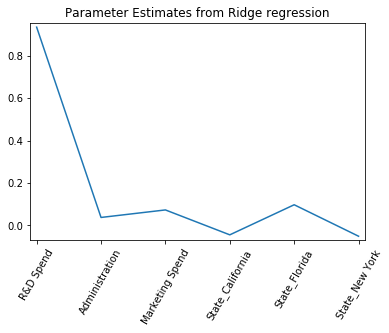

In [352]:
plt.plot(range(len(col)), ridge_coef)
plt.xticks(range(len(col)), col.values, rotation=60) 
plt.margins(0.02)
plt.title("Parameter Estimates from Ridge regression")
plt.show()

### Regularization path of Ridge Regression

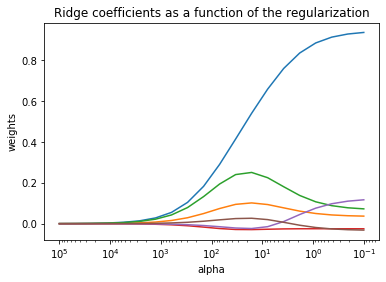

In [262]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
n_alphas = 20
alphas = np.logspace(-1, 5, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

### Elastic Net Regularization

#### The elastic net is a regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge methods respectively. Below I took two values of alpha 1 and 0.1 and got 0.246 and 0.04 MSE for test set respectively. But the best thing is to use gridsearch CV but in the elastic net, it was not converging, therefore I used ElasticNetCV.

In [286]:
from sklearn.linear_model import ElasticNet 
  
# Train the model 
e_net = ElasticNet(alpha = 1) 
e_net.fit(X_train, y_train) 
  
# calculate the prediction and mean square error 
y_pred_elastic = e_net.predict(X_test) 
mean_squared_error = np.mean((y_pred_elastic - y_test)**2) 
print("Mean Squared Error on test set", mean_squared_error) 


Mean Squared Error on test set 0.24570228145339912


In [289]:
from sklearn.linear_model import ElasticNet 
  
# Train the model 
e_net = ElasticNet(alpha = 0.1) 
e_net.fit(X_train, y_train) 
  
# calculate the prediction and mean square error 
y_pred_elastic = e_net.predict(X_test) 
mean_squared_error = np.mean((y_pred_elastic - y_test)**2) 
print("Mean Squared Error on test set", mean_squared_error) 

Mean Squared Error on test set 0.040416742126923894


In [291]:
e_net_coeff = pd.DataFrame() 
e_net_coeff["Columns"] = df3.columns 
e_net_coeff['Coefficient Estimate'] = pd.Series(e_net.coef_) 
e_net_coeff

,Columns,Coefficient Estimate
0,R&D Spend,0.830830
1,Administration,0.009697
2,Marketing Spend,0.107388
3,State_California,-0.000000
4,State_Florida,0.000000
5,State_New York,0.000000


In [363]:
from sklearn.linear_model import ElasticNetCV
from sklearn.datasets import make_regression

In [383]:
X, y = make_regression(n_features=5, random_state=0)
regr = ElasticNetCV(cv=5, random_state=0)
regr.fit(X, y)
ElasticNetCV(cv=5, random_state=0)


ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

In [384]:
print(regr.alpha_)

print(regr.intercept_)

0.20442189961657878
-1.714706126537628


In [385]:
coef = regr.coef_
print(coef)

[87.58917346 40.95192289 12.38280803 78.9086817  37.00686883]


## Conclusion:

### From the above analyses, we can say that the performance of Lasso is best, as it provides minimum MSE among all three methods, i.e., Linear Model, Lasso and Ridge. I found that all the assumption for linear model were met. Residual plot is drawn suggesting homegenity, independent and normality are met. R&D Spend variable is highly correlated with Profit and significant at 5% level of significance suggesting the decision would be primarily based on this variable. In State, coefficient of Florida is only positive suggesting more profit can be made by selecting the company in the state of Florida. However, State variable is not significant so model suggests that pattern across the State find in the sample is due to randomness and State will not play any significant role in the Profit.